In [34]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import StandardScaler
from gensim.models import Word2Vec

# Import data

In [35]:
# Specify the path to your JSON file
json_file_path = 'News_Category_Dataset_IS_course.json'

# Load only the first 1000 lines from the JSON file
with open(json_file_path, 'r') as file:
    data = [json.loads(line) for line in file.readlines()[:1000]]

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Drop rows with missing short_description
df = df.dropna(subset=['short_description'])

# Encode categories into numerical labels
df['category_label'] = pd.Categorical(df['category']).codes

# Select relevant columns
df = df[['short_description', 'category_label']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['short_description'], df['category_label'], test_size=0.2, random_state=42)


# TF-IDF Vectorizer

In [36]:
# Convert text data to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Define cross-validation strategy (StratifiedKFold is suitable for classification tasks)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Transform the entire dataset
X_tfidf = vectorizer.fit_transform(df['short_description'])

# Word2Vec Vectorizer

In [38]:
# Tokenize your text data into a list of words
tokenized_X_train = [text.split() for text in X_train]
tokenized_X_test = [text.split() for text in X_test]

# Train Word2Vec model on the tokenized training data
word2vec_model = Word2Vec(sentences=tokenized_X_train, vector_size=100, window=5, min_count=1, workers=4)

# Function to get the average word embedding for a text
def get_average_word_embedding(text, model):
    words = text.split()
    embeddings = [model.wv[word] for word in words if word in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

# Get average word embeddings for training and test data
X_train_word2vec = np.vstack([get_average_word_embedding(text, word2vec_model) for text in X_train])
X_test_word2vec = np.vstack([get_average_word_embedding(text, word2vec_model) for text in X_test])

# Standardize the features
scaler = StandardScaler()
X_train_word2vec = scaler.fit_transform(X_train_word2vec)
X_test_word2vec = scaler.transform(X_test_word2vec)

# Logistic Regression Model

TF-IDF Vectorizer

In [39]:
# Logistic Regression model
logistic_regression_model = LogisticRegression(max_iter=1000)

# Cross-validation for Logistic Regression
logistic_regression_cv_scores = cross_val_score(logistic_regression_model, X_tfidf, df['category_label'], cv=cv, scoring='accuracy')
print("Logistic Regression Cross-Validation Scores:", logistic_regression_cv_scores)
print("Mean Accuracy:", logistic_regression_cv_scores.mean())

# Hyperparameter tuning for Logistic Regression
logistic_regression_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

logistic_regression_model = LogisticRegression(max_iter=1000)
logistic_regression_grid = GridSearchCV(logistic_regression_model, logistic_regression_params, cv=cv, scoring='accuracy')
logistic_regression_grid.fit(X_train_tfidf, y_train)

# Print the best hyperparameters for Logistic Regression
print("Best Hyperparameters for Logistic Regression:")
print(logistic_regression_grid.best_params_)

# Make predictions on the test set using the best Logistic Regression model
logistic_regression_predictions = logistic_regression_grid.predict(X_test_tfidf)

# Evaluate the Logistic Regression model
logistic_regression_accuracy = accuracy_score(y_test, logistic_regression_predictions)
print("\nLogistic Regression Accuracy (with hyperparameter tuning):", logistic_regression_accuracy)
print(classification_report(y_test, logistic_regression_predictions))


c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Logistic Regression Cross-Validation Scores: [0.66       0.66       0.69       0.68686869 0.68686869 0.67676768
 0.65656566 0.67676768 0.6969697  0.5959596 ]
Mean Accuracy: 0.6686767676767678


c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Best Hyperparameters for Logistic Regression:
{'C': 10}

Logistic Regression Accuracy (with hyperparameter tuning): 0.7085427135678392
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         5
           2       1.00      0.17      0.29         6
           3       0.70      0.80      0.75        56
           4       0.00      0.00      0.00         5
           5       1.00      0.33      0.50         3
           6       0.00      0.00      0.00         2
           7       0.71      0.94      0.81        89
           9       0.71      0.28      0.40        18
          10       0.00      0.00      0.00         4
          12       0.62      0.50      0.56        10

    accuracy                           0.71       199
   macro avg       0.43      0.28      0.30       199
weighted avg       0.66      0.71      0.65       199



c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Word2Vec Vectorizer

In [41]:
# Logistic Regression model
logistic_regression_model_word2vec = LogisticRegression(max_iter=10000)

# Cross-validation for Logistic Regression
logistic_regression_cv_scores_word2vec = cross_val_score(logistic_regression_model_word2vec, X_train_word2vec, y_train, cv=cv, scoring='accuracy')
print("\nLogistic Regression (Word2Vec) Cross-Validation Scores:", logistic_regression_cv_scores_word2vec)
print("Mean Accuracy:", logistic_regression_cv_scores_word2vec.mean())

# Hyperparameter tuning for Logistic Regression
logistic_regression_params_word2vec = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

logistic_regression_grid_word2vec = GridSearchCV(logistic_regression_model_word2vec, logistic_regression_params_word2vec, cv=cv, scoring='accuracy')
logistic_regression_grid_word2vec.fit(X_train_word2vec, y_train)

# Print the best hyperparameters for Logistic Regression with Word2Vec
print("\nBest Hyperparameters for Logistic Regression (Word2Vec):")
print(logistic_regression_grid_word2vec.best_params_)

# Make predictions on the test set using the best Logistic Regression model with Word2Vec
logistic_regression_predictions_word2vec = logistic_regression_grid_word2vec.predict(X_test_word2vec)

# Evaluate the Logistic Regression model with Word2Vec
logistic_regression_accuracy_word2vec = accuracy_score(y_test, logistic_regression_predictions_word2vec)
print("\nLogistic Regression Accuracy (Word2Vec with hyperparameter tuning):", logistic_regression_accuracy_word2vec)
print(classification_report(y_test, logistic_regression_predictions_word2vec))

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(



Logistic Regression (Word2Vec) Cross-Validation Scores: [0.4875     0.475      0.475      0.55       0.53164557 0.5443038
 0.43037975 0.41772152 0.44303797 0.53164557]
Mean Accuracy: 0.488623417721519


c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(



Best Hyperparameters for Logistic Regression (Word2Vec):
{'C': 0.01}

Logistic Regression Accuracy (Word2Vec with hyperparameter tuning): 0.4623115577889447
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         6
           3       0.36      0.29      0.32        56
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         2
           7       0.49      0.85      0.63        89
           9       0.00      0.00      0.00        18
          10       0.00      0.00      0.00         4
          12       0.00      0.00      0.00        10

    accuracy                           0.46       199
   macro avg       0.08      0.10      0.09       199
weighted avg       0.32      0.46      0.37       199



c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

# Random Forest Model

TF-IDF Vectorizer

In [42]:
# Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Cross-validation for Random Forest
random_forest_cv_scores = cross_val_score(random_forest_model, X_tfidf, df['category_label'], cv=cv, scoring='accuracy')
print("\nRandom Forest Cross-Validation Scores:", random_forest_cv_scores)
print("Mean Accuracy:", random_forest_cv_scores.mean())

# Hyperparameter tuning for Random Forest
random_forest_params = {'n_estimators': [100, 150, 200], 'max_depth': [20, 30, 40, 50]}

random_forest_model = RandomForestClassifier(random_state=42)
random_forest_grid = GridSearchCV(random_forest_model, random_forest_params, cv=cv, scoring='accuracy')
random_forest_grid.fit(X_train_tfidf, y_train)

# Print the best hyperparameters for Random Forest
print("\nBest Hyperparameters for Random Forest:")
print(random_forest_grid.best_params_)

# Make predictions on the test set using the best Random Forest model
random_forest_predictions = random_forest_grid.predict(X_test_tfidf)

# Evaluate the Random Forest model
random_forest_accuracy = accuracy_score(y_test, random_forest_predictions)
print("\nRandom Forest Accuracy (with hyperparameter tuning):", random_forest_accuracy)
print(classification_report(y_test, random_forest_predictions))

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(



Random Forest Cross-Validation Scores: [0.65       0.65       0.71       0.67676768 0.66666667 0.6969697
 0.64646465 0.72727273 0.65656566 0.60606061]
Mean Accuracy: 0.6686767676767678


c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(



Best Hyperparameters for Random Forest:
{'max_depth': 50, 'n_estimators': 150}

Random Forest Accuracy (with hyperparameter tuning): 0.5879396984924623
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         6
           3       0.63      0.57      0.60        56
           4       0.00      0.00      0.00         5
           5       1.00      0.33      0.50         3
           6       0.00      0.00      0.00         2
           7       0.58      0.93      0.72        89
           9       0.00      0.00      0.00        18
          10       0.00      0.00      0.00         4
          12       0.25      0.10      0.14        10

    accuracy                           0.59       199
   macro avg       0.22      0.18      0.18       199
weighted avg       0.47      0.59      0.50       199



c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Word2Vec Vectorizer

In [43]:
# Random Forest model
random_forest_model_word2vec = RandomForestClassifier(random_state=42)

# Cross-validation for Random Forest
random_forest_cv_scores_word2vec = cross_val_score(random_forest_model_word2vec, X_train_word2vec, y_train, cv=cv, scoring='accuracy')
print("\nRandom Forest (Word2Vec) Cross-Validation Scores:", random_forest_cv_scores_word2vec)
print("Mean Accuracy:", random_forest_cv_scores_word2vec.mean())

# Hyperparameter tuning for Random Forest
random_forest_params_word2vec = {'n_estimators': [100, 150, 200], 'max_depth': [20, 30, 40, 50]}

random_forest_grid_word2vec = GridSearchCV(random_forest_model_word2vec, random_forest_params_word2vec, cv=cv, scoring='accuracy')
random_forest_grid_word2vec.fit(X_train_word2vec, y_train)

# Print the best hyperparameters for Random Forest with Word2Vec
print("\nBest Hyperparameters for Random Forest (Word2Vec):")
print(random_forest_grid_word2vec.best_params_)

# Make predictions on the test set using the best Random Forest model with Word2Vec
random_forest_predictions_word2vec = random_forest_grid_word2vec.predict(X_test_word2vec)

# Evaluate the Random Forest model with Word2Vec
random_forest_accuracy_word2vec = accuracy_score(y_test, random_forest_predictions_word2vec)
print("\nRandom Forest Accuracy (Word2Vec with hyperparameter tuning):", random_forest_accuracy_word2vec)
print(classification_report(y_test, random_forest_predictions_word2vec))

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(



Random Forest (Word2Vec) Cross-Validation Scores: [0.5125     0.5125     0.4875     0.4875     0.55696203 0.51898734
 0.51898734 0.49367089 0.49367089 0.58227848]
Mean Accuracy: 0.5164556962025317


c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(



Best Hyperparameters for Random Forest (Word2Vec):
{'max_depth': 20, 'n_estimators': 200}

Random Forest Accuracy (Word2Vec with hyperparameter tuning): 0.45226130653266333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         6
           3       0.34      0.21      0.26        56
           4       0.00      0.00      0.00         5
           5       1.00      0.33      0.50         3
           6       0.00      0.00      0.00         2
           7       0.47      0.87      0.61        89
           9       0.00      0.00      0.00        18
          10       0.00      0.00      0.00         4
          12       0.00      0.00      0.00        10

    accuracy                           0.45       199
   macro avg       0.17      0.13      0.12       199
weighted avg       0.32      0.45      0.36       199



c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

# KNN Model

TF-IDF Vectorizer

In [44]:
from sklearn.neighbors import KNeighborsClassifier

# KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors

# Cross-validation for KNN
knn_cv_scores = cross_val_score(knn_model, X_tfidf, df['category_label'], cv=cv, scoring='accuracy')
print("\nKNN Cross-Validation Scores:", knn_cv_scores)
print("Mean Accuracy:", knn_cv_scores.mean())

# Hyperparameter tuning for KNN
knn_params = {'n_neighbors': range(1, 11)}

knn_grid = GridSearchCV(knn_model, knn_params, cv=cv, scoring='accuracy')
knn_grid.fit(X_train_tfidf, y_train)

# Print the best hyperparameters for KNN
print("\nBest Hyperparameters for KNN:")
print(knn_grid.best_params_)

# Make predictions on the test set using the best KNN model
knn_predictions = knn_grid.predict(X_test_tfidf)

# Evaluate the KNN model
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("\nKNN Accuracy (with hyperparameter tuning):", knn_accuracy)
print(classification_report(y_test, knn_predictions))


c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(



KNN Cross-Validation Scores: [0.67       0.63       0.68       0.66666667 0.67676768 0.68686869
 0.68686869 0.65656566 0.67676768 0.64646465]
Mean Accuracy: 0.6676969696969697


c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(



Best Hyperparameters for KNN:
{'n_neighbors': 10}

KNN Accuracy (with hyperparameter tuning): 0.6482412060301508
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         6
           3       0.63      0.80      0.71        56
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         2
           7       0.69      0.85      0.76        89
           9       0.62      0.28      0.38        18
          10       0.33      0.25      0.29         4
          12       0.50      0.20      0.29        10

    accuracy                           0.65       199
   macro avg       0.25      0.22      0.22       199
weighted avg       0.58      0.65      0.60       199



c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Word2Vec Vectorizer

In [45]:
# KNN model
knn_model_word2vec = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors

# Cross-validation for KNN
knn_cv_scores_word2vec = cross_val_score(knn_model_word2vec, X_train_word2vec, y_train, cv=cv, scoring='accuracy')
print("\nKNN (Word2Vec) Cross-Validation Scores:", knn_cv_scores_word2vec)
print("Mean Accuracy:", knn_cv_scores_word2vec.mean())

# Hyperparameter tuning for KNN
knn_params_word2vec = {'n_neighbors': range(1, 11)}

knn_grid_word2vec = GridSearchCV(knn_model_word2vec, knn_params_word2vec, cv=cv, scoring='accuracy')
knn_grid_word2vec.fit(X_train_word2vec, y_train)

# Print the best hyperparameters for KNN with Word2Vec
print("\nBest Hyperparameters for KNN (Word2Vec):")
print(knn_grid_word2vec.best_params_)

# Make predictions on the test set using the best KNN model with Word2Vec
knn_predictions_word2vec = knn_grid_word2vec.predict(X_test_word2vec)

# Evaluate the KNN model with Word2Vec
knn_accuracy_word2vec = accuracy_score(y_test, knn_predictions_word2vec)
print("\nKNN Accuracy (Word2Vec with hyperparameter tuning):", knn_accuracy_word2vec)
print(classification_report(y_test, knn_predictions_word2vec))

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(



KNN (Word2Vec) Cross-Validation Scores: [0.4125     0.4125     0.425      0.4875     0.46835443 0.51898734
 0.43037975 0.43037975 0.5443038  0.48101266]
Mean Accuracy: 0.4610917721518987

Best Hyperparameters for KNN (Word2Vec):
{'n_neighbors': 9}

KNN Accuracy (Word2Vec with hyperparameter tuning): 0.4472361809045226
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         6
           3       0.37      0.29      0.32        56
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         2
           7       0.47      0.82      0.60        89
           9       0.00      0.00      0.00        18
          10       0.00      0.00      0.00         4
          12       0.00      0.00      0.00        10

    accuracy                 

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

# SVM Model

TF-IDF Vectorizer

In [46]:
from sklearn.svm import SVC

# SVM model
svm_model = SVC(kernel='linear')  # You can adjust the kernel and other parameters

# Cross-validation for SVM
svm_cv_scores = cross_val_score(svm_model, X_tfidf, df['category_label'], cv=cv, scoring='accuracy')
print("\nSVM Cross-Validation Scores:", svm_cv_scores)
print("Mean Accuracy:", svm_cv_scores.mean())

# Hyperparameter tuning for SVM
svm_params = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']}  # You can adjust the range of C and kernel

svm_grid = GridSearchCV(svm_model, svm_params, cv=cv, scoring='accuracy')
svm_grid.fit(X_train_tfidf, y_train)

# Print the best hyperparameters for SVM
print("\nBest Hyperparameters for SVM:")
print(svm_grid.best_params_)

# Make predictions on the test set using the best SVM model
svm_predictions = svm_grid.predict(X_test_tfidf)

# Evaluate the SVM model
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("\nSVM Accuracy (with hyperparameter tuning):", svm_accuracy)
print(classification_report(y_test, svm_predictions))


c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(



SVM Cross-Validation Scores: [0.73       0.68       0.72       0.6969697  0.70707071 0.72727273
 0.66666667 0.74747475 0.72727273 0.62626263]
Mean Accuracy: 0.7028989898989899


c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(



Best Hyperparameters for SVM:
{'C': 1, 'kernel': 'linear'}

SVM Accuracy (with hyperparameter tuning): 0.6934673366834171
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         6
           3       0.71      0.75      0.73        56
           4       0.00      0.00      0.00         5
           5       1.00      0.33      0.50         3
           6       0.00      0.00      0.00         2
           7       0.68      0.96      0.79        89
           9       0.83      0.28      0.42        18
          10       0.00      0.00      0.00         4
          12       0.62      0.50      0.56        10

    accuracy                           0.69       199
   macro avg       0.35      0.26      0.27       199
weighted avg       0.63      0.69      0.63       199



c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Word2Vec Vectorizer

In [47]:
# SVM model
svm_model_word2vec = SVC(kernel='linear')  # You can adjust the kernel and other parameters

# Cross-validation for SVM
svm_cv_scores_word2vec = cross_val_score(svm_model_word2vec, X_train_word2vec, y_train, cv=cv, scoring='accuracy')
print("\nSVM (Word2Vec) Cross-Validation Scores:", svm_cv_scores_word2vec)
print("Mean Accuracy:", svm_cv_scores_word2vec.mean())

# Hyperparameter tuning for SVM
svm_params_word2vec = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']}  # You can adjust the range of C and kernel

svm_grid_word2vec = GridSearchCV(svm_model_word2vec, svm_params_word2vec, cv=cv, scoring='accuracy')
svm_grid_word2vec.fit(X_train_word2vec, y_train)

# Print the best hyperparameters for SVM with Word2Vec
print("\nBest Hyperparameters for SVM (Word2Vec):")
print(svm_grid_word2vec.best_params_)

# Make predictions on the test set using the best SVM model with Word2Vec
svm_predictions_word2vec = svm_grid_word2vec.predict(X_test_word2vec)

# Evaluate the SVM model with Word2Vec
svm_accuracy_word2vec = accuracy_score(y_test, svm_predictions_word2vec)
print("\nSVM Accuracy (Word2Vec with hyperparameter tuning):", svm_accuracy_word2vec)
print(classification_report(y_test, svm_predictions_word2vec))

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(



SVM (Word2Vec) Cross-Validation Scores: [0.5125     0.475      0.425      0.4        0.48101266 0.46835443
 0.34177215 0.43037975 0.44303797 0.5443038 ]
Mean Accuracy: 0.4521360759493671


c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(



Best Hyperparameters for SVM (Word2Vec):
{'C': 0.1, 'kernel': 'linear'}

SVM Accuracy (Word2Vec with hyperparameter tuning): 0.45226130653266333
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      0.20      0.29         5
           2       0.00      0.00      0.00         6
           3       0.41      0.36      0.38        56
           4       1.00      0.40      0.57         5
           5       1.00      0.33      0.50         3
           6       0.00      0.00      0.00         2
           7       0.50      0.73      0.59        89
           9       0.50      0.06      0.10        18
          10       0.00      0.00      0.00         4
          12       0.00      0.00      0.00        10

    accuracy                           0.45       199
   macro avg       0.36      0.19      0.22       199
weighted avg       0.44      0.45      0.41       199



c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

# Naive Bayes Model

TF-IDF Vectorizer

In [48]:
from sklearn.naive_bayes import MultinomialNB

# Naive Bayes model (Multinomial Naive Bayes)
naive_bayes_model = MultinomialNB()

# Cross-validation for Naive Bayes
naive_bayes_cv_scores = cross_val_score(naive_bayes_model, X_tfidf, df['category_label'], cv=cv, scoring='accuracy')
print("\nNaive Bayes Cross-Validation Scores:", naive_bayes_cv_scores)
print("Mean Accuracy:", naive_bayes_cv_scores.mean())

# Hyperparameter tuning for Naive Bayes
naive_bayes_params = {'alpha': [0.1, 0.5, 1.0, 2.0]}  # You can adjust the range of alpha

naive_bayes_grid = GridSearchCV(naive_bayes_model, naive_bayes_params, cv=cv, scoring='accuracy')
naive_bayes_grid.fit(X_train_tfidf, y_train)

# Print the best hyperparameters for Naive Bayes
print("\nBest Hyperparameters for Naive Bayes:")
print(naive_bayes_grid.best_params_)

# Make predictions on the test set using the best Naive Bayes model
naive_bayes_predictions = naive_bayes_grid.predict(X_test_tfidf)

# Evaluate the Naive Bayes model
naive_bayes_accuracy = accuracy_score(y_test, naive_bayes_predictions)
print("\nNaive Bayes Accuracy (with hyperparameter tuning):", naive_bayes_accuracy)
print(classification_report(y_test, naive_bayes_predictions))



Naive Bayes Cross-Validation Scores: [0.64       0.61       0.64       0.65656566 0.67676768 0.6969697
 0.66666667 0.67676768 0.70707071 0.60606061]
Mean Accuracy: 0.6576868686868688

Best Hyperparameters for Naive Bayes:
{'alpha': 0.1}

Naive Bayes Accuracy (with hyperparameter tuning): 0.678391959798995
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         6
           3       0.72      0.73      0.73        56
           4       0.00      0.00      0.00         5
           5       1.00      0.33      0.50         3
           6       0.00      0.00      0.00         2
           7       0.67      0.97      0.79        89
           9       0.75      0.17      0.27        18
          10       0.00      0.00      0.00         4
          12       0.50      0.40      0.44        10

    accuracy                           0.6

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set

Word2Vec Vectorizer

In [50]:
from sklearn.naive_bayes import GaussianNB

# Naive Bayes model (Gaussian Naive Bayes) for Word2Vec
# MultinominalNB model is designed for non-negative integer features, and Word2Vec vectors can contain negative values ->
# That is why we are using GaussianNB model. 
naive_bayes_model_word2vec = GaussianNB()

# Cross-validation for Naive Bayes with Word2Vec
naive_bayes_cv_scores_word2vec = cross_val_score(naive_bayes_model_word2vec, X_train_word2vec, y_train, cv=cv, scoring='accuracy')
print("\nNaive Bayes (Word2Vec) Cross-Validation Scores:", naive_bayes_cv_scores_word2vec)
print("Mean Accuracy:", naive_bayes_cv_scores_word2vec.mean())

# No hyperparameter tuning is needed for Gaussian Naive Bayes

# Fit the Naive Bayes model with Word2Vec to the training data
naive_bayes_model_word2vec.fit(X_train_word2vec, y_train)

# Make predictions on the test set
naive_bayes_predictions_word2vec = naive_bayes_model_word2vec.predict(X_test_word2vec)

# Evaluate the Naive Bayes model with Word2Vec
naive_bayes_accuracy_word2vec = accuracy_score(y_test, naive_bayes_predictions_word2vec)
print("\nNaive Bayes Accuracy (Word2Vec):", naive_bayes_accuracy_word2vec)
print(classification_report(y_test, naive_bayes_predictions_word2vec))


Naive Bayes (Word2Vec) Cross-Validation Scores: [0.0375     0.025      0.025      0.05       0.02531646 0.02531646
 0.02531646 0.05063291 0.06329114 0.02531646]
Mean Accuracy: 0.035268987341772154

Naive Bayes Accuracy (Word2Vec): 0.04020100502512563
              precision    recall  f1-score   support

           0       0.01      1.00      0.03         1
           1       0.03      0.20      0.05         5
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00        56
           4       0.12      0.20      0.15         5
           5       1.00      0.33      0.50         3
           6       0.02      0.50      0.03         2
           7       0.38      0.03      0.06        89
           9       0.00      0.00      0.00        18
          10       0.00      0.00      0.00         4
          12       0.00      0.00      0.00        10

    accuracy                           0.04       199
   macro avg       0.14      0.21      0.07 

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packa

Very low accuracy because Gaussian Naive Bayes assumes that the features are normally distributed.

# Decision Tree Model

TF-IDF Vectorizer

In [51]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Cross-validation for Decision Tree
decision_tree_cv_scores = cross_val_score(decision_tree_model, X_tfidf, df['category_label'], cv=cv, scoring='accuracy')
print("\nDecision Tree Cross-Validation Scores:", decision_tree_cv_scores)
print("Mean Accuracy:", decision_tree_cv_scores.mean())

# Hyperparameter tuning for Decision Tree
decision_tree_params = {'max_depth': [None, 10, 20, 30, 40], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}

decision_tree_grid = GridSearchCV(decision_tree_model, decision_tree_params, cv=cv, scoring='accuracy')
decision_tree_grid.fit(X_train_tfidf, y_train)

# Print the best hyperparameters for Decision Tree
print("\nBest Hyperparameters for Decision Tree:")
print(decision_tree_grid.best_params_)

# Make predictions on the test set using the best Decision Tree model
decision_tree_predictions = decision_tree_grid.predict(X_test_tfidf)

# Evaluate the Decision Tree model
decision_tree_accuracy = accuracy_score(y_test, decision_tree_predictions)
print("\nDecision Tree Accuracy (with hyperparameter tuning):", decision_tree_accuracy)
print(classification_report(y_test, decision_tree_predictions))


c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(



Decision Tree Cross-Validation Scores: [0.56       0.6        0.61       0.60606061 0.55555556 0.60606061
 0.64646465 0.56565657 0.5959596  0.46464646]
Mean Accuracy: 0.581040404040404


c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(



Best Hyperparameters for Decision Tree:
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10}

Decision Tree Accuracy (with hyperparameter tuning): 0.5477386934673367
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         6
           3       0.62      0.46      0.53        56
           4       0.20      0.20      0.20         5
           5       0.75      1.00      0.86         3
           6       0.00      0.00      0.00         2
           7       0.56      0.85      0.68        89
           9       0.50      0.11      0.18        18
          10       0.00      0.00      0.00         4
          12       0.33      0.10      0.15        10

    accuracy                           0.55       199
   macro avg       0.27      0.25      0.24       199
weighted avg       0.50      0.55      0.49       199



c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Word2Vec Vectorizer

In [52]:
# Decision Tree model
decision_tree_model_word2vec = DecisionTreeClassifier(random_state=42)

# Cross-validation for Decision Tree
decision_tree_cv_scores_word2vec = cross_val_score(decision_tree_model_word2vec, X_train_word2vec, y_train, cv=cv, scoring='accuracy')
print("\nDecision Tree (Word2Vec) Cross-Validation Scores:", decision_tree_cv_scores_word2vec)
print("Mean Accuracy:", decision_tree_cv_scores_word2vec.mean())

# Hyperparameter tuning for Decision Tree
decision_tree_params_word2vec = {'max_depth': [None, 10, 20, 30, 40], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}

decision_tree_grid_word2vec = GridSearchCV(decision_tree_model_word2vec, decision_tree_params_word2vec, cv=cv, scoring='accuracy')
decision_tree_grid_word2vec.fit(X_train_word2vec, y_train)

# Print the best hyperparameters for Decision Tree with Word2Vec
print("\nBest Hyperparameters for Decision Tree (Word2Vec):")
print(decision_tree_grid_word2vec.best_params_)

# Make predictions on the test set using the best Decision Tree model with Word2Vec
decision_tree_predictions_word2vec = decision_tree_grid_word2vec.predict(X_test_word2vec)

# Evaluate the Decision Tree model with Word2Vec
decision_tree_accuracy_word2vec = accuracy_score(y_test, decision_tree_predictions_word2vec)
print("\nDecision Tree Accuracy (Word2Vec with hyperparameter tuning):", decision_tree_accuracy_word2vec)
print(classification_report(y_test, decision_tree_predictions_word2vec))

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(



Decision Tree (Word2Vec) Cross-Validation Scores: [0.4        0.325      0.3875     0.325      0.43037975 0.35443038
 0.3164557  0.3164557  0.30379747 0.41772152]
Mean Accuracy: 0.35767405063291136


c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(



Best Hyperparameters for Decision Tree (Word2Vec):
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}

Decision Tree Accuracy (Word2Vec with hyperparameter tuning): 0.4120603015075377
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         6
           3       0.35      0.30      0.32        56
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         2
           7       0.47      0.73      0.57        89
           9       0.00      0.00      0.00        18
          10       0.00      0.00      0.00         4
          12       0.00      0.00      0.00        10

    accuracy                           0.41       199
   macro avg       0.07      0.09      0.08       199
weighted avg       0.31      0.41      0.3

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

# Majority Classifier Model

TF-IDF Vectorizer

In [53]:
from sklearn.dummy import DummyClassifier

# Majority Classifier model
majority_classifier_model = DummyClassifier(strategy='most_frequent')

# Cross-validation for Majority Classifier
majority_classifier_cv_scores = cross_val_score(majority_classifier_model, X_tfidf, df['category_label'], cv=cv, scoring='accuracy')
print("\nMajority Classifier Cross-Validation Scores:", majority_classifier_cv_scores)
print("Mean Accuracy:", majority_classifier_cv_scores.mean())

# Since there are no hyperparameters to tune, we don't need GridSearchCV for Majority Classifier

# Fit the Majority Classifier model to the training data
majority_classifier_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
majority_classifier_predictions = majority_classifier_model.predict(X_test_tfidf)

# Evaluate the Majority Classifier model
majority_classifier_accuracy = accuracy_score(y_test, majority_classifier_predictions)
print("\nMajority Classifier Accuracy:", majority_classifier_accuracy)
print(classification_report(y_test, majority_classifier_predictions))



Majority Classifier Cross-Validation Scores: [0.48       0.49       0.49       0.49494949 0.49494949 0.49494949
 0.49494949 0.49494949 0.48484848 0.48484848]
Mean Accuracy: 0.49044444444444435

Majority Classifier Accuracy: 0.4472361809045226
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00        56
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         2
           7       0.45      1.00      0.62        89
           9       0.00      0.00      0.00        18
          10       0.00      0.00      0.00         4
          12       0.00      0.00      0.00        10

    accuracy                           0.45       199
   macro avg       0.04      0.09      0.06       19

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packa

Word2Vec Vectorizer

In [54]:
# Majority Classifier model
majority_classifier_model_word2vec = DummyClassifier(strategy='most_frequent')

# Cross-validation for Majority Classifier
majority_classifier_cv_scores_word2vec = cross_val_score(majority_classifier_model_word2vec, X_train_word2vec, y_train, cv=cv, scoring='accuracy')
print("\nMajority Classifier (Word2Vec) Cross-Validation Scores:", majority_classifier_cv_scores_word2vec)
print("Mean Accuracy:", majority_classifier_cv_scores_word2vec.mean())

# Fit the Majority Classifier model to the training data
majority_classifier_model_word2vec.fit(X_train_word2vec, y_train)

# Make predictions on the test set
majority_classifier_predictions_word2vec = majority_classifier_model_word2vec.predict(X_test_word2vec)

# Evaluate the Majority Classifier model with Word2Vec embeddings
majority_classifier_accuracy_word2vec = accuracy_score(y_test, majority_classifier_predictions_word2vec)
print("\nMajority Classifier (Word2Vec) Accuracy:", majority_classifier_accuracy_word2vec)
print(classification_report(y_test, majority_classifier_predictions_word2vec))


Majority Classifier (Word2Vec) Cross-Validation Scores: [0.5        0.5        0.5        0.5        0.50632911 0.50632911
 0.50632911 0.50632911 0.49367089 0.49367089]
Mean Accuracy: 0.5012658227848101

Majority Classifier (Word2Vec) Accuracy: 0.4472361809045226
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00        56
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         2
           7       0.45      1.00      0.62        89
           9       0.00      0.00      0.00        18
          10       0.00      0.00      0.00         4
          12       0.00      0.00      0.00        10

    accuracy                           0.45       199
   macro avg       0.04      0.

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python311\Lib\site-packa

# Visualize results

Comparison of models using TF-IDF Vectorizer

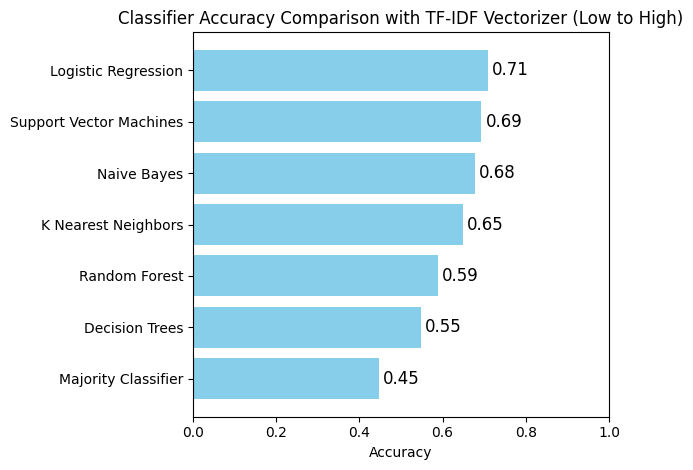

In [55]:
# Create a plot for the results
from matplotlib import pyplot as plt


results = [logistic_regression_accuracy, random_forest_accuracy, knn_accuracy,
            svm_accuracy, naive_bayes_accuracy, decision_tree_accuracy, majority_classifier_accuracy]
classifiers = ['Logistic Regression', 'Random Forest', 'K Nearest Neighbors',
            'Support Vector Machines', 'Naive Bayes', 'Decision Trees', 'Majority Classifier']

# Sort results and classifiers in ascending order of accuracy
sorted_results, sorted_classifiers = zip(*sorted(zip(results, classifiers)))

# Create a bar plot
plt.barh(sorted_classifiers, sorted_results, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Classifier Accuracy Comparison with TF-IDF Vectorizer (Low to High)')
plt.xlim(0, 1.0)  # Set the x-axis limits from 0 to 1 for accuracy values

# Annotate the bars with accuracy values
for i, result in enumerate(sorted_results):
    plt.text(result + 0.01, i, f'{result:.2f}', va='center', fontsize=12)

plt.tight_layout()
plt.show()

Comparison of models using Word2Vec Vectorizer

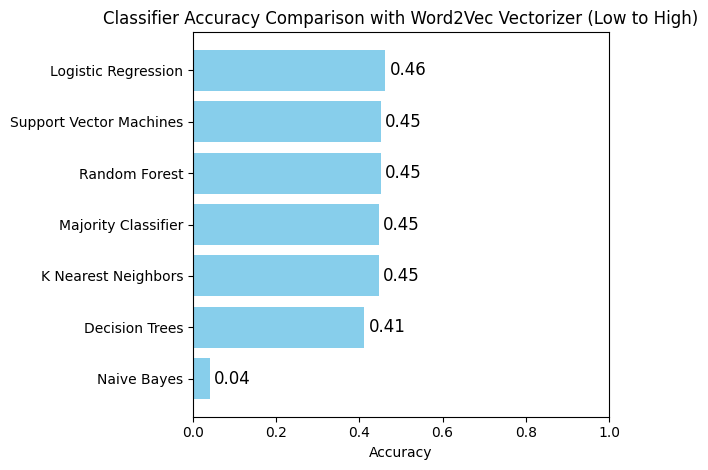

In [56]:
# Create a plot for the results with Word2Vec vectorizer
results_word2vec = [logistic_regression_accuracy_word2vec, random_forest_accuracy_word2vec, knn_accuracy_word2vec,
                    svm_accuracy_word2vec, naive_bayes_accuracy_word2vec, decision_tree_accuracy_word2vec, majority_classifier_accuracy_word2vec]
classifiers = ['Logistic Regression', 'Random Forest', 'K Nearest Neighbors',
            'Support Vector Machines', 'Naive Bayes', 'Decision Trees', 'Majority Classifier']

# Sort results and classifiers in ascending order of accuracy
sorted_results_word2vec, sorted_classifiers = zip(*sorted(zip(results_word2vec, classifiers)))

# Create a bar plot for Word2Vec vectorizer
plt.barh(sorted_classifiers, sorted_results_word2vec, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Classifier Accuracy Comparison with Word2Vec Vectorizer (Low to High)')
plt.xlim(0, 1.0)  # Set the x-axis limits from 0 to 1 for accuracy values

# Annotate the bars with accuracy values
for i, result in enumerate(sorted_results_word2vec):
    plt.text(result + 0.01, i, f'{result:.2f}', va='center', fontsize=12)

plt.tight_layout()
plt.show()